In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import sys
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/QRT_FOOT_DATA_CHALLENGE')

from Utilities.data_process import scores_to_target
from Utilities.get_data import get_test
from Utilities.get_data import get_train
from Utilities.get_data import get_data_path
from Utilities.bench_validation import test_bench
from Utilities.bench_validation import get_bench_random_forest
from Utilities.bench_validation import test_bench_random_forest

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive/QRT_FOOT_DATA_CHALLENGE/Utilities/Data')
train_data, train_scores = get_train()
test_data = get_test()

In [ ]:
scaler = MinMaxScaler()
train_data[:] = scaler.fit_transform(train_data)
test_data[:] = scaler.transform(test_data)
train_data.head()

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,0.3,0.2,0.5,0.2,0.1,0.2,0.2,0.5,0.3,0.6,...,0.5,0.5,0.4,0.0,0.6,0.8,0.4,0.3,0.2,0.3
1,0.6,0.8,0.3,0.6,0.5,0.8,0.7,1.0,0.6,0.8,...,0.0,0.0,0.3,0.1,0.8,0.4,1.0,0.0,0.5,0.3
2,0.4,0.2,0.5,0.2,0.8,0.1,0.1,0.2,0.2,0.7,...,0.6,1.0,0.4,0.4,0.0,0.8,0.3,0.0,0.9,0.6
3,0.7,0.5,0.5,0.6,0.6,0.9,0.9,0.2,0.2,0.0,...,0.0,0.0,0.1,0.2,0.0,0.5,0.6,0.3,NaN,0.2
4,0.3,0.3,0.2,0.3,0.4,0.4,0.3,0.4,0.4,0.7,...,0.1,0.0,0.4,0.4,0.9,0.4,0.1,0.4,0.6,0.5


We keep track of the number of nans as it's information that one could use to drop or not a feature.

In [ ]:
nans_by_features = train_data.isna().sum(axis=0) / len(train_data)
features_with_nans = nans_by_features[nans_by_features > 0].index.tolist()

According to the tests done in the missing values notebook, the optimal method to fill the nan values, using a logistic regression as benchmark was to use the median of the feature from the k = 13 nearest neighboors.

<Axes: >

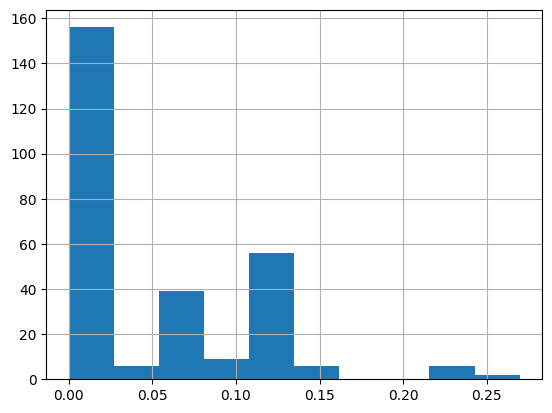

In [ ]:
nans_by_features.hist()

At most the features has 25% of their values that are nans

In [ ]:
os.chdir('/content/drive/My Drive/QRT_FOOT_DATA_CHALLENGE/Clustering')
from clustering_methods import kmeans_clustering
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from clustering_methods import kmeans_clustering

In [ ]:
os.chdir('/content/drive/My Drive/QRT_FOOT_DATA_CHALLENGE/FeaturesEngineering')
from filling import fill_with_kmeans

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data_filled, train_target_filled = fill_with_kmeans(train_data, train_scores, n_clusters = 13)
test_data_filled, train_target_filled = fill_with_kmeans(test_data, train_scores, n_clusters = 13)
train_data_normalized = train_data_filled.copy()
test_data_normalized = test_data_filled.copy()
train_data_non_normalized = train_data_filled.copy()
train_data_non_normalized[:] = scaler.inverse_transform(train_data_filled)
test_data_non_normalized = test_data_filled.copy()
test_data_non_normalized[:] = scaler.inverse_transform(test_data_filled)

In [ ]:
train_data_filled.isna().sum().sum()

0

# Dimensionality Reduction

We will reduce the dimensionality, in order to reduce the overfitting and increasing the accuracy by three different criterae:

* Measuring the relative importance of each feature and dropping the least important
* The number of nan values within each feature
* Dropping the correlated features




In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest_bench = get_bench_random_forest()

# Features Importance

In [ ]:
random_forest_bench.fit(train_data_normalized, train_target_filled)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [ ]:
df_feature_importances = pd.DataFrame({'importance' : random_forest_bench.feature_importances_, 'feature' : train_data_filled.columns})

In [ ]:
file_path = '/content/drive/My Drive/QRT_FOOT_DATA_CHALLENGE/Utilities/Data'
os.chdir(file_path)
df_feature_importances.to_csv('df_feature_importances.csv', index=False)

In [ ]:
df_feature_importances.head()

,importance,feature
0,0.004480,HOME_TEAM_SHOTS_TOTAL_season_sum
1,0.007539,HOME_TEAM_SHOTS_INSIDEBOX_season_sum
2,0.003440,HOME_TEAM_SHOTS_OFF_TARGET_season_sum
3,0.007399,HOME_TEAM_SHOTS_ON_TARGET_season_sum
4,0.002917,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum


We normalize the importance

In [ ]:
df_feature_importances.sort_values(by='importance', ascending=False).head()

,importance,feature
173,0.008719,AWAY_TEAM_BALL_POSSESSION_season_average
20,0.008182,HOME_TEAM_GAME_WON_season_sum
24,0.008153,HOME_TEAM_SHOTS_INSIDEBOX_season_average
45,0.008135,HOME_TEAM_GAME_WON_season_average
23,0.007829,HOME_TEAM_SHOTS_TOTAL_season_average


Unsurprisingly the most important features are the number of games previously won, the ball possession...

array([[<Axes: title={'center': 'importance'}>]], dtype=object)

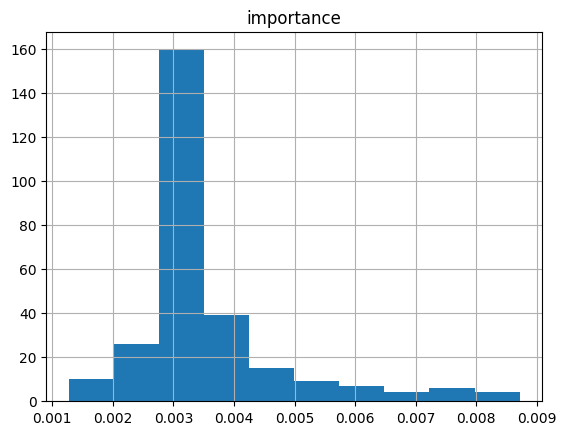

In [ ]:
df_feature_importances.hist()

In [ ]:
import plotly.express as px
fig = px.line(x=range(len(df_feature_importances)), y=df_feature_importances.sort_values(by='importance', ascending=False)['importance'].values, title='Feature Importance')
fig.show()

In [ ]:
threshold = 0.3

def get_features_high_importance(df_feature_importances, threshold = threshold):
  return df_feature_importances.sort_values(by='importance', ascending=False).iloc[0:int(len(df_feature_importances) * threshold)]['feature'].tolist()

def get_features_low_importance(df_feature_importances, threshold = threshold):
  return df_feature_importances.sort_values(by='importance', ascending=True).iloc[0:int(len(df_feature_importances) * threshold)]['feature'].tolist()

def get_features_with_most_nans(nans_by_features, threshold = threshold):
  return nans_by_features.sort_values(ascending=False).iloc[0:int(threshold*len(nans_by_features))].index.tolist()

In [ ]:
features_low_importance = get_features_low_importance(df_feature_importances, threshold = 0.25)

In [ ]:
features_low_importance

['AWAY_TEAM_REDCARDS_5_last_match_average',
 'AWAY_TEAM_REDCARDS_5_last_match_sum',
 'HOME_TEAM_REDCARDS_5_last_match_average',
 'HOME_TEAM_REDCARDS_5_last_match_sum',
 'HOME_TEAM_REDCARDS_5_last_match_std',
 'AWAY_TEAM_REDCARDS_5_last_match_std',
 'HOME_TEAM_PENALTIES_5_last_match_average',
 'AWAY_TEAM_PENALTIES_5_last_match_std',
 'AWAY_TEAM_PENALTIES_5_last_match_sum',
 'HOME_TEAM_PENALTIES_5_last_match_sum',
 'AWAY_TEAM_GAME_DRAW_5_last_match_sum',
 'AWAY_TEAM_SUBSTITUTIONS_5_last_match_sum',
 'AWAY_TEAM_PENALTIES_5_last_match_average',
 'HOME_TEAM_GAME_DRAW_5_last_match_sum',
 'HOME_TEAM_PENALTIES_5_last_match_std',
 'HOME_TEAM_SUBSTITUTIONS_5_last_match_sum',
 'AWAY_TEAM_GAME_DRAW_5_last_match_average',
 'HOME_TEAM_GAME_DRAW_5_last_match_average',
 'AWAY_TEAM_INJURIES_5_last_match_sum',
 'HOME_TEAM_SUBSTITUTIONS_5_last_match_std',
 'HOME_TEAM_INJURIES_5_last_match_std',
 'AWAY_TEAM_SUBSTITUTIONS_5_last_match_average',
 'AWAY_TEAM_SHOTS_OUTSIDEBOX_5_last_match_average',
 'AWAY_TEA

We try to see if we get a loss of accuracy by dropping the 25% least predictive

In [ ]:
score_bench_log_reg = test_bench(train_data_non_normalized, train_target_filled)
score_bench_rf = test_bench_random_forest(train_data_filled, train_target_filled)

In [ ]:
train_data_normalized_low_importance_dropped = train_data_normalized.drop(columns = features_low_importance).copy()
train_data_non_normalized_low_importance_dropped = train_data_non_normalized.drop(columns = features_low_importance).copy()
test_data_normalized_low_importance_dropped = test_data_normalized.drop(columns = features_low_importance).copy()
test_data_non_normalized_low_importance_dropped = test_data_non_normalized.drop(columns = features_low_importance).copy()

In [ ]:
score_bench_log_reg = test_bench(train_data_non_normalized_low_importance_dropped, train_target_filled)
score_bench_rf = test_bench_random_forest(train_data_filled_low_importance_dropped, train_target_filled)

In [ ]:
file_path = '/content/drive/My Drive/QRT_FOOT_DATA_CHALLENGE/Utilities/Data'
os.chdir(file_path)
train_data_non_normalized_low_importance_dropped.to_csv('train_data_non_normalized_low_importance_dropped.csv', index=False)
train_data_normalized_low_importance_dropped.to_csv('train_data_normalized_low_importance_dropped.csv', index=False)
test_data_non_normalized_low_importance_dropped.to_csv('test_data_non_normalized_low_importance_dropped.csv', index=False)
test_data_normalized_low_importance_dropped.to_csv('test_data_normalized_low_importance_dropped.csv', index=False)

Let's see if there is any feature with the most nans among the most predictive ones, which would be problematic

In [ ]:
features_most_nans = get_features_with_most_nans(nans_by_features, threshold = 0.25)

In [ ]:
interesection = [feature for feature in features_most_nans if feature in features_low_importance]

In [ ]:
interesection

In [ ]:
score_bench_log_reg = test_bench(train_data_non_normalized, train_target_filled)
score_bench_rf = test_bench_random_forest(train_data_filled, train_target_filled)

In [ ]:
train_data_filled_dropped = train_data_filled.drop(columns = interesection).copy()
train_data_non_normalized_dropped = train_data_non_normalized.drop(columns = interesection).copy()

In [ ]:
score_bench_log_reg = test_bench(train_data_non_normalized_dropped, train_target_filled)
score_bench_rf = test_bench_random_forest(train_data_filled_dropped, train_target_filled)

# Drop of correlated features

In [ ]:
os.chdir('/content/drive/My Drive/QRT_FOOT_DATA_CHALLENGE')

from Utilities.get_data import get_test_data_normalized_features_low_importance_dropped
from Utilities.get_data import get_test_data_non_normalized_features_low_importance_dropped
from Utilities.get_data import get_train_data_normalized_features_low_importance_dropped
from Utilities.get_data import get_train_data_non_normalized_features_low_importance_dropped
from Utilities.get_data import get_features_importance

In [ ]:
os.chdir('/content/drive/My Drive/QRT_FOOT_DATA_CHALLENGE/Utilities/Data')

train_data_filled_dropped, train_scores = get_train_data_normalized_features_low_importance_dropped()
train_data_non_normalized_dropped, train_scores = get_train_data_non_normalized_features_low_importance_dropped()
test_data_filled_dropped = get_test_data_normalized_features_low_importance_dropped()
test_data_non_normalized_dropped = get_test_data_non_normalized_features_low_importance_dropped()
features_importance = get_features_importance()

In [ ]:
features_importance.head()

,importance,feature
0,0.004480,HOME_TEAM_SHOTS_TOTAL_season_sum
1,0.007539,HOME_TEAM_SHOTS_INSIDEBOX_season_sum
2,0.003440,HOME_TEAM_SHOTS_OFF_TARGET_season_sum
3,0.007399,HOME_TEAM_SHOTS_ON_TARGET_season_sum
4,0.002917,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum


In [ ]:
train_data_filled_dropped_corr = train_data_filled_dropped.copy()
test_data_filled_dropped_corr = test_data_filled_dropped.copy()

In [ ]:
features_to_drop = []
corr_matrix = train_data_filled_dropped_corr.corr()

In order to select which feature to drop in case two are highlty correlated, we compute the features importance of each feature with a random Forest

In [ ]:
threshold = 0.85

for i in range(corr_matrix.shape[0]):
  for j in range(i+1, corr_matrix.shape[1]):
    if abs(corr_matrix.iloc[i,j]) > threshold:
      importance_first_feature = features_importance[features_importance['feature'] == corr_matrix.columns[i]]['importance'].values[0]
      importance_second_feature = features_importance[features_importance['feature'] == corr_matrix.columns[j]]['importance'].values[0]
      if importance_first_feature > importance_second_feature:
        features_to_drop.append(corr_matrix.columns[j])
      else:
        features_to_drop.append(corr_matrix.columns[i])

In [ ]:
features_to_drop

['HOME_TEAM_SHOTS_TOTAL_season_sum',
 'HOME_TEAM_SHOTS_INSIDEBOX_season_sum',
 'HOME_TEAM_SHOTS_OFF_TARGET_season_sum',
 'HOME_TEAM_SHOTS_ON_TARGET_season_average',
 'HOME_TEAM_PASSES_season_sum',
 'HOME_TEAM_PASSES_season_sum',
 'HOME_TEAM_SUCCESSFUL_PASSES_season_average',
 'HOME_TEAM_PASSES_season_average',
 'HOME_TEAM_SUCCESSFUL_PASSES_season_average',
 'HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average',
 'HOME_TEAM_SAVES_season_average',
 'HOME_TEAM_CORNERS_season_sum',
 'HOME_TEAM_FOULS_season_sum',
 'HOME_TEAM_YELLOWCARDS_season_average',
 'HOME_TEAM_OFFSIDES_season_average',
 'HOME_TEAM_ATTACKS_season_sum',
 'HOME_TEAM_DANGEROUS_ATTACKS_season_average',
 'HOME_TEAM_GOALS_season_average',
 'HOME_TEAM_GAME_WON_season_average',
 'HOME_TEAM_GAME_LOST_season_sum',
 'HOME_TEAM_SUCCESSFUL_PASSES_season_average',
 'HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average',
 'HOME_TEAM_PASSES_season_average',
 'HOME_TEAM_PASSES_5_last_match_average',
 'HOME_TEAM_SUCCESSFUL_PASSES_seas

In [ ]:
train_data_filled_dropped_corr = train_data_filled_dropped_corr.drop(columns = features_to_drop).copy()
test_data_filled_dropped_corr = test_data_filled_dropped_corr.drop(columns = features_to_drop).copy()

In [ ]:
file_path = '/content/drive/My Drive/QRT_FOOT_DATA_CHALLENGE/Utilities/Data'
os.chdir(file_path)
train_data_filled_dropped_corr.to_csv('train_data_filled_dropped_corr.csv', index=False)
test_data_filled_dropped_corr.to_csv('test_data_filled_dropped_corr.csv', index=False)